## 로지스틱 회귀  
  
로지스틱 회귀 : 선형 회귀 방식을 분류에 적용한 알고리즘, 시그모이드 함수 최적선을 찾아 반환 값을 확률로 간주해 분류 결정  

시그모이드 함수 : a= $$ y={1 \over {1+e^{-x}}} $$  
- 음의 무한대나 양의 무한대로 가더라도 y 값은 항상 0과 1 사이로 반환  
  
LogisticRegression 클래스 : 경사 하강법 외에 다양한 최적화 방안 존재
- lbfigs : 메모리 공간 절약, CPU 코어가 많은 경우에는 최적화를 병렬로 수행
- liblinear : 다차원이고 작은 데이트 세트에서 효과적으로 동작, 국소 최적화 이슈 존재, 병렬 최적화 불가
- newton-cg : 정교한 최적화 가능, 대용량의 데이터에서 속도 감소
- sag : Stochastic Average Gradient로서 경사 하강법 기반의 최적화 적용, 대용량의 데이터에서 빠르게 최적화
- saga : sag와 유사한 최적화 방식, L1 정규화 가능
- 보통 lbfgs와 liblinear를 선택

In [7]:
#위스콘신 유방암 데이터 세트 생성

import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 예측 성능 영향을 받을 수 있기 때문에 정규 분포 형태의 표준 스케일링 적용
# StandardScaler( )로 평균이 0, 분산 1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train , X_test, y_train , y_test = train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)

In [10]:
#정확도와 ROC-AUC 값 계산
from sklearn.metrics import accuracy_score, roc_auc_score

# 로지스틱 회귀를 이용하여 학습 및 예측 수행.
# solver 인자값을 생성자로 입력하지 않으면 solver='lbfgs'
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)

# accuracy와 roc_auc 측정
print('accuracy: {0:.3f}, roc_auc:{1:.3f}'.format(accuracy_score(y_test, lr_preds),
                                                  roc_auc_score(y_test , lr_preds)))

accuracy: 0.977, roc_auc:0.972


In [11]:
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']

# 여러개의 solver 값별로 LogisticRegression 학습 후 성능 평가
for solver in solvers:
    #특정 solver의 최적화 반복 횟수가 너무 많기 때문에 max_iter를 600으로 제한
    lr_clf = LogisticRegression(solver=solver, max_iter=600)
    lr_clf.fit(X_train, y_train)
    lr_preds = lr_clf.predict(X_test)
    
    # accuracy와 roc_auc 측정
    print('solver:{0}, accuracy: {1:.3f}, roc_auc:{2:.3f}'.format(solver,
                                                                  accuracy_score(y_test, lr_preds),
                                                                  roc_auc_score(y_test , lr_preds)))

solver:lbfgs, accuracy: 0.977, roc_auc:0.972
solver:liblinear, accuracy: 0.982, roc_auc:0.979
solver:newton-cg, accuracy: 0.977, roc_auc:0.972
solver:sag, accuracy: 0.982, roc_auc:0.979
solver:saga, accuracy: 0.982, roc_auc:0.979


데이터 세트가 작기 때문에 큰 차이가 없음.
그럼에도 전반적으로 liblinear의 성능이 약간 높기 때문에 liblinear로 수록

LogisticRegression 클래스의 주요 하이퍼 파라미터  
penalty : 규제의 유형을 설정하며 l2는 L2 규제를, l1 설정 시에는 L1 규제, 기본은 'l2'  
C: 규제 강도 조절, alpha 값의 역수, C 값이 작을수록 규제 강도가 크다.  

liblinear,saga의 경우 L1, L2 규제가 모두 가능  
lbfgs, newton-cg, sag의 경우는 L2만 가능

In [13]:
from sklearn.model_selection import GridSearchCV

params={'solver':['liblinear', 'lbfgs'],
        'penalty':['l2', 'l1'],
        'C':[0.01, 0.1, 1, 1, 5, 10]}

lr_clf = LogisticRegression()

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=3 )
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}'.format(grid_clf.best_params_,
                                                  grid_clf.best_score_))

최적 하이퍼 파라미터:{'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}, 최적 평균 정확도:0.965


로지스틱 회귀는 가볍고 빠르지만, 이진 분류 예측 성능이 매우 뛰어남. -> 이진 분류 기본 모델로 사용  
희소한 데이터 세트 분류에도 뛰어난 성능을 보여 텍스트 분류에서도 사용

## 5.8 회귀 트리

회귀를 위한 트리 생성, 이를 기반으로 회귀 예측  
회귀 트리는 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값을 계산  
모든 트리 기반의 알고리즘은 회귀에도 가능

In [15]:
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

# 보스턴 데이터 세트 로드
boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

bostonDF['PRICE'] = boston.target
y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1,inplace=False)

rf = RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 교차 검증의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 교차 검증의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))


 5 교차 검증의 개별 Negative MSE scores:  [ -7.88 -13.14 -20.57 -46.23 -18.88]
 5 교차 검증의 개별 RMSE scores :  [2.81 3.63 4.54 6.8  4.34]
 5 교차 검증의 평균 RMSE : 4.423 


In [16]:
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    rmse_scores  = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('##### ',model.__class__.__name__ , ' #####')
    print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행 
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:  
    get_model_cv_prediction(model, X_data, y_target)

#####  DecisionTreeRegressor  #####
 5 교차 검증의 평균 RMSE : 5.978 
#####  RandomForestRegressor  #####
 5 교차 검증의 평균 RMSE : 4.423 
#####  GradientBoostingRegressor  #####
 5 교차 검증의 평균 RMSE : 4.269 
#####  XGBRegressor  #####
 5 교차 검증의 평균 RMSE : 4.251 
#####  LGBMRegressor  #####
 5 교차 검증의 평균 RMSE : 4.646 


회귀 트리 regressor 클래스는선형 회귀와 다른 처리 방식이므로 회귀 계수를 제공하는 coef_ 속성이 없음.  
대신 feature_importacs_를 이용해 피처별 중요도 파악

<AxesSubplot: >

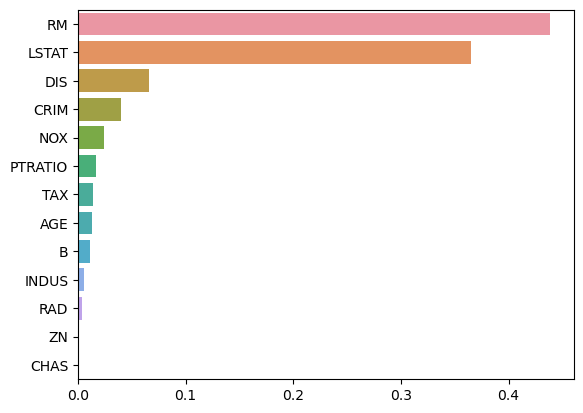

In [18]:
import seaborn as sns
%matplotlib inline

rf_reg = RandomForestRegressor(n_estimators=1000)

# 앞 예제에서 만들어진 X_data, y_target 데이터 셋을 적용하여 학습합니다.   
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns )
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x= feature_series, y=feature_series.index)

(100, 2)


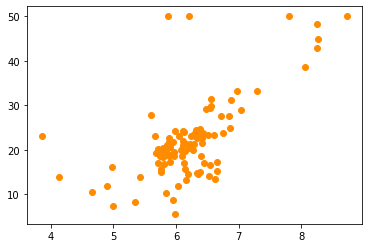

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

bostonDF_sample = bostonDF[['RM','PRICE']]
bostonDF_sample = bostonDF_sample.sample(n=100,random_state=0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM , bostonDF_sample.PRICE,c="darkorange")

In [11]:
import numpy as np
from sklearn.linear_model import LinearRegression

# 선형 회귀와 결정 트리 기반의 Regressor 생성. DecisionTreeRegressor의 max_depth는 각각 2, 7
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth=7)

# 실제 예측을 적용할 테스트용 데이터 셋을 4.5 ~ 8.5 까지 100개 데이터 셋 생성. 
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1, 1)

# 보스턴 주택가격 데이터에서 시각화를 위해 피처는 RM만, 그리고 결정 데이터인 PRICE 추출
X_feature = bostonDF_sample['RM'].values.reshape(-1,1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1,1)

# 학습과 예측 수행. 
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)


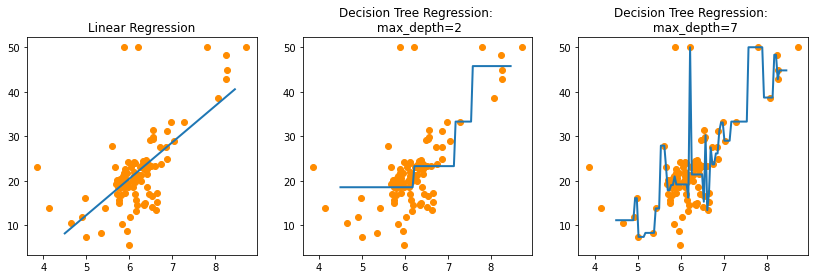

In [12]:
fig , (ax1, ax2, ax3) = plt.subplots(figsize=(14,4), ncols=3)

# X축값을 4.5 ~ 8.5로 변환하며 입력했을 때, 선형 회귀와 결정 트리 회귀 예측 선 시각화
# 선형 회귀로 학습된 모델 회귀 예측선 
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax1.plot(X_test, pred_lr,label="linear", linewidth=2 )

# DecisionTreeRegressor의 max_depth를 2로 했을 때 회귀 예측선 
ax2.set_title('Decision Tree Regression: \n max_depth=2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax2.plot(X_test, pred_rf2, label="max_depth:3", linewidth=2 )

# DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선 
ax3.set_title('Decision Tree Regression: \n max_depth=7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax3.plot(X_test, pred_rf7, label="max_depth:7", linewidth=2)

선형 회귀는 직선으로 예측 회귀선을 표현/ 회귀 트리의 경우 분할되는 데이터 지점에 따라 계단 형태로 회귀선 표현  
max_depth=7일 때는 이상치까지 학습하여 회귀선을 만들기 때문에 과적합 이슈